# Flu Vaccinations Project - Modeling Iterations

---

## Summary of Business Understanding

**End Users**: Public health officials, and policy makers

**True business problem**:
- Predicting who is vaccinated or not accurately? (Deliverable: Model)
- What are the factors that influence people get H1N1 vaccine or not?  (Deliverable: Analysis)


**Context**:
- False negative: Saying people did not get the vaccine when they actually did. 
- Outcome: Not a big problem

- False positive: Saying people got the vaccine when they actually did not. 
- Outcome: Big problem

**Evaluation**:
We will focus on accuracy, f1, and precision scores for our model iterations in order to minimize False Positives, because in our business context false positives are a much more costly mistake than false negatives.

- **Accuracy**
- **Precision**
- Recall
- **F1-Score**

---

In [1]:
# Importing Relevant Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost     # extreme gradient boosting

# To visualize the 100 many the columns in data
pd.options.display.max_columns=100

The following evaluate function is copied from (https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb). 

We will use this function to evaluate the performance of our models:

In [2]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    Code source link: 
    https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_tr)
        test_out = estimator.decision_function(X_te)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_tr)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_te)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, cmap="plasma", normalize='true')

## Data Understanding

In [3]:
!ls Data

LabelsandFeatures.txt
test_set_features.csv
training_set_features.csv
training_set_labels.csv


In [4]:
data1 = pd.read_csv('Data/training_set_features.csv')
data1.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
data2 = pd.read_csv('Data/training_set_labels.csv')
data2.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [6]:
data2['seasonal_vaccine'].value_counts(normalize=True)  

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [7]:
data2['h1n1_vaccine'].value_counts(normalize=True)   # class imbalance problem

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [8]:
df = data1.merge(data2, how='left', on='respondent_id')
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [10]:
df.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [11]:
# Exploring numerical columns
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


In [12]:
# Exploring object columns
df[[c for c in df.columns if df[c].dtype =='object']].describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


## Exploratory Data Analysis

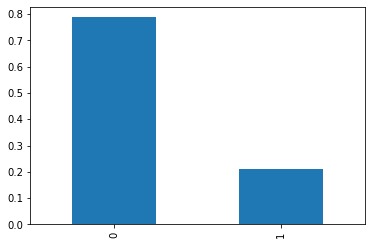

In [13]:
# Target variable distribution
df['h1n1_vaccine'].value_counts(normalize=True).plot(kind='bar');

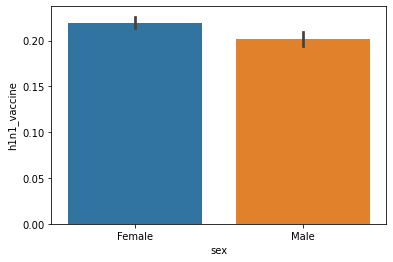

In [14]:
# Gender and h1n1 vaccination status bar graph
sns.barplot(x=df['sex'], y=df['h1n1_vaccine']);

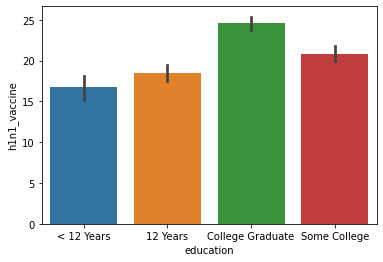

In [15]:
# Education level percentage distribution of the vaccinated people 
sns.barplot(x=df['education'], y=df['h1n1_vaccine']*100);

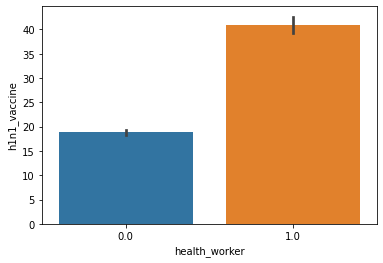

In [16]:
# Distribution of health workers who got the vaccine
sns.barplot(x=df['health_worker'], y=df['h1n1_vaccine']*100);

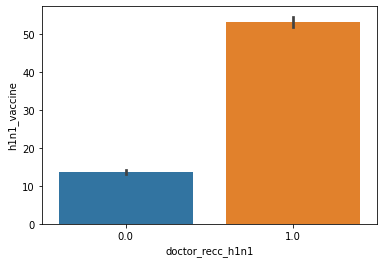

In [17]:
# Doctor recommendation vs H1N1 vaccine
sns.barplot(x=df['doctor_recc_h1n1'], y=df['h1n1_vaccine']*100);

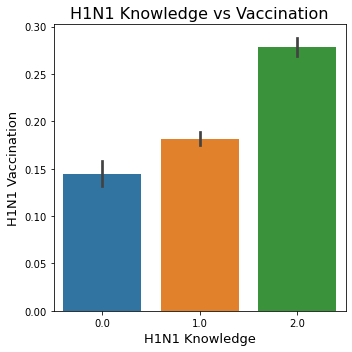

In [18]:
# Setting the size of the plot
plt.figure(figsize = (5,5))
# Creating the bar plot with X = h1n1_knowledge and Y = h1n1_vaccine
sns.barplot(data = df, x=df['h1n1_knowledge'], y=df['h1n1_vaccine'])
# Setting title and labels
plt.title('H1N1 Knowledge vs Vaccination', fontsize=16)
plt.xlabel('H1N1 Knowledge', fontsize=13)
plt.ylabel('H1N1 Vaccination', fontsize=13)
plt.tight_layout();

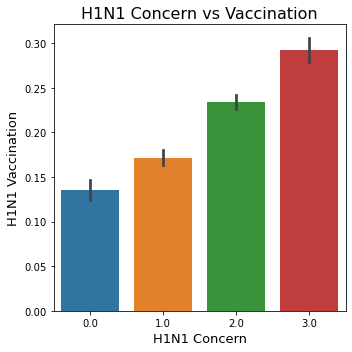

In [19]:
# Setting the size of the plot
plt.figure(figsize = (5,5))
# Creating the bar plot with X = h1n1_knowledge and Y = h1n1_concern
sns.barplot(data = df, x=df['h1n1_concern'], y=df['h1n1_vaccine'])
# Setting title and labels
plt.title('H1N1 Concern vs Vaccination', fontsize=16)
plt.xlabel('H1N1 Concern', fontsize=13)
plt.ylabel('H1N1 Vaccination', fontsize=13)
plt.tight_layout();

## Data Preparation

In [20]:
# Define our X and y
X = df.drop(columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y = df['h1n1_vaccine']

In [21]:
# Train - Holdout Set Split
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [22]:
# Regular Train Test Split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [23]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [24]:
print(f'Numerical Columns:', num_cols)
print('\n')
print(f'Object Columns (with less than 10 unique values):', ohe_cols)
print('\n')
print(f'Object Columns (with more than 10 unique values):', freq_cols)

Numerical Columns: ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']


Object Columns (with less than 10 unique values): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']


Object Columns (with more than 10 unique values): ['hhs_geo_region', 'employment_industry', 'employment_occupation']


In [25]:
# Preprocessing with Pipelines
num_transformer = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=100, random_state=42)),   # replace missing values by IterativeImputer
    ('minmaxscaler', MinMaxScaler())                                    # Scale the numbers by MinMaxScaler
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # replace missing categories by SimpleImputer
    ('ohe_encoder', OneHotEncoder(handle_unknown='ignore'))                     # Transform each category into a new column
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)), # replace category names with frequency counts by CountEncoder
    ('freq_imputer', IterativeImputer(max_iter=100, random_state=42))            # replace missing values by IterativeImputer
])

In [26]:
# Preprocessor defined using ColumnTransformer by packaging the all components together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [27]:
# Fitting preprocessor to see the components as a whole
preprocessor.fit(X_tr)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral...
                                 ['age_group', 'education', 'race', 'sex',
                                  'in

In [28]:
# Just out of curiosity, see what this looks like 
X_tr_transformed = preprocessor.transform(X_tr)
X_tr_transformed.shape

(19228, 59)

In [29]:
# Visualize it with Pandas dataframe 
pd.DataFrame(X_tr_transformed).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,1.000000,0.5,0.016076,0.963804,0.038064,0.894508,0.0,1.000000,0.0,0.116478,0.141558,1.0,0.0,1.000000,0.779010,0.75,0.296807,0.75,0.75,0.279800,0.75,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.106407,0.499168,0.504213
1,0.666667,1.0,0.016076,0.000000,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,0.0,0.110629,0.920662,0.75,0.765602,0.25,0.75,0.759933,0.25,0.333333,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.160235,0.340961,0.371854
2,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,0.0,1.000000,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.00,1.00,0.279800,0.00,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.076659,0.499168,0.504213
3,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.25,0.75,0.279800,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.499168,0.504213
4,0.333333,1.0,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,1.0,1.000000,0.920662,0.25,0.062409,0.00,0.75,0.279800,0.25,0.666667,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.340961,0.371854


By using pipelines, we imputed missing values and transformed columns. Now, our data is ready for modeling.

## Modeling

### Baseline Understanding

- Let's use DummyClassifier to make prediction based on the most frequent class in the target variable, which is 0 in our case. 

In [30]:
dummy_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])

In [31]:
dummy_model.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                

Training Scores:
Train Accuracy: 0.7875494071146245
Train Precision: 0.0
Train Recall: 0.0
Train F1-Score: 0.0
**********
Testing Scores:
Test Accuracy: 0.7874376039933444
Test Precision: 0.0
Test Recall: 0.0
Test F1-Score: 0.0


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


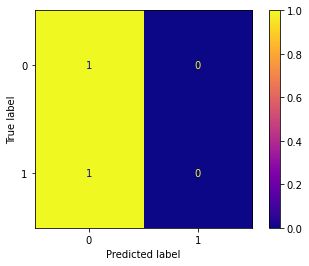

In [32]:
# Evaluate dummy model
evaluate(dummy_model, X_tr, X_te, y_tr, y_te, roc_auc='skip')

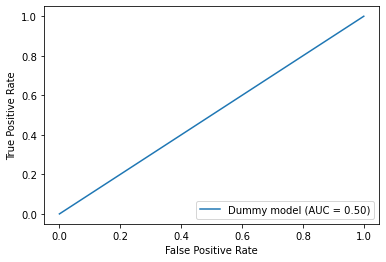

In [33]:
plot_roc_curve(dummy_model, X_tr, y_tr, name='Dummy model'); 

So, the mean of the accuracy score is a little over 78% if we always guess the majority class, which is 0 in this case.

## Modeling Iterations

Now we will start to iterate over multiple models!

### MODEL 1: Decision Tree Classifier

In [34]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [35]:
cross_validate(clf, X_tr, y_tr, return_train_score=True)

{'fit_time': array([4.39310431, 4.25072002, 4.66701388, 4.5051651 , 4.72182631]),
 'score_time': array([0.07872486, 0.09105659, 0.1216476 , 0.10944581, 0.11482096]),
 'test_score': array([0.77015081, 0.76469059, 0.7774311 , 0.78153446, 0.76853056]),
 'train_score': array([1., 1., 1., 1., 1.])}

We see that, we have overfitting problem with DecisionTreeClassifier()!

In [36]:
# Let's do GridSearchCV
param_grid = {
    "classifier__max_depth": [1, 2, 5],
    "classifier__min_samples_split": [2, 10],
    "classifier__class_weight": ['balanced', None]   # we have class-imbalance issue, change the weights
}


In [37]:
grid = GridSearchCV(clf, param_grid, scoring=['f1','precision'], refit = 'f1')

In [38]:
output_clf = grid.fit(X_tr, y_tr)

In [39]:
output_clf.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 5,
 'classifier__min_samples_split': 2}

In [40]:
output_clf.best_estimator_.fit(X_tr, y_tr)

te_preds = output_clf.best_estimator_.predict(X_te)

In [41]:
# pd.DataFrame(grid.cv_results_)  # if you want to see the details of each combination in the grid

In [42]:
# output_clf.best_estimator_

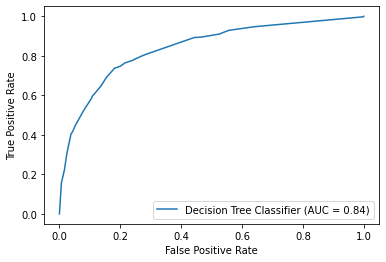

In [43]:
plot_roc_curve(output_clf.best_estimator_, X_te, y_te, name='Decision Tree Classifier'); 

Training Scores:
Train Accuracy: 0.7920220511753693
Train Precision: 0.5071858288770054
Train Recall: 0.7429620563035496
Train F1-Score: 0.6028404012315026
**********
Testing Scores:
Test Accuracy: 0.7886855241264559
Test Precision: 0.5019710906701709
Test Recall: 0.7475538160469667
Test F1-Score: 0.6006289308176102


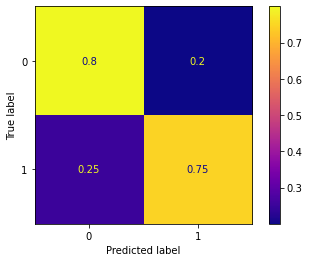

In [44]:
evaluate(output_clf.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 2: Logistic Regression

In [45]:
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

In [46]:
cross_validate(logreg, X_tr, y_tr, return_train_score=True)

{'fit_time': array([5.13154554, 4.80325723, 4.761801  , 4.4557817 , 4.96392822]),
 'score_time': array([0.11639833, 0.11096239, 0.11183476, 0.10595131, 0.11579728]),
 'test_score': array([0.83333333, 0.83515341, 0.82683307, 0.84577373, 0.82756827]),
 'train_score': array([0.83539202, 0.8340918 , 0.83545703, 0.83104726, 0.83559774])}

In [47]:
# Let's do GridSearchCV
param_grid = {
    "classifier__solver": ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    "classifier__C" : [1, 0.1, 0.01], # regularization parameter
    "classifier__class_weight": ['balanced', None]
}

In [48]:
grid = GridSearchCV(logreg, param_grid, scoring=['f1','precision'], refit = 'f1')

In [49]:
output_logreg = grid.fit(X_tr, y_tr)

In [50]:
output_logreg.best_params_

{'classifier__C': 1,
 'classifier__class_weight': 'balanced',
 'classifier__solver': 'lbfgs'}

In [51]:
output_logreg.best_estimator_.fit(X_tr, y_tr)

te_preds_logreg = output_logreg.best_estimator_.predict(X_te)

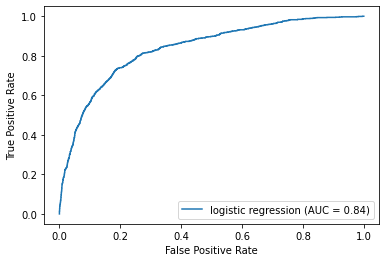

In [52]:
plot_roc_curve(output_logreg.best_estimator_, X_te, y_te, name='logistic regression');

Training Scores:
Train Accuracy: 0.775691699604743
Train Precision: 0.4817774936061381
Train Recall: 0.7378212974296205
Train F1-Score: 0.5829223479354027
**********
Testing Scores:
Test Accuracy: 0.778910149750416
Test Precision: 0.48693435309114086
Test Recall: 0.7475538160469667
Test F1-Score: 0.5897336935546121


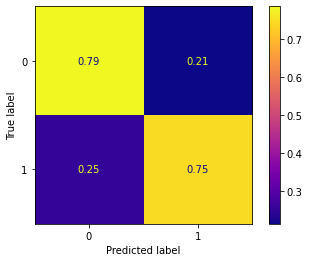

In [53]:
evaluate(output_logreg.best_estimator_, X_tr, X_te, y_tr, y_te)

In [54]:
# pd.DataFrame(grid.cv_results_)  # if you want to see the details of each combination in the grid

### MODEL 3: Random Forest

In [55]:
rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [56]:
cross_validate(rfc, X_tr, y_tr, return_train_score=True)

{'fit_time': array([6.53936863, 6.08080053, 6.12362242, 5.83421469, 6.45905304]),
 'score_time': array([0.14779329, 0.15195203, 0.14959621, 0.14643884, 0.16425729]),
 'test_score': array([0.84893396, 0.85361414, 0.84659386, 0.85019506, 0.84577373]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [57]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth" : [2, 5], 
    "classifier__min_samples_leaf": [1, 2],
    "classifier__class_weight" :['balanced', 'balanced_subsample']  
    # class weight should be balanced or balanced_subsample - we have imbalance issue.
}


In [58]:
grid = GridSearchCV(rfc, param_grid, scoring=['f1','precision'], refit = 'f1')

In [59]:
output_rfc = grid.fit(X_tr, y_tr)

In [60]:
output_rfc.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 200}

In [61]:
output_rfc.best_estimator_.fit(X_tr, y_tr)

te_preds_rfc = output_rfc.best_estimator_.predict(X_te)

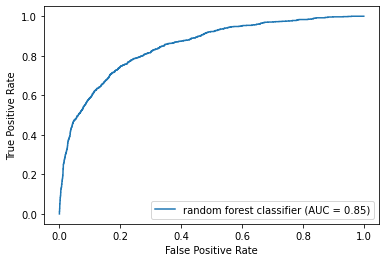

In [62]:
plot_roc_curve(output_rfc.best_estimator_, X_te, y_te, name='random forest classifier');

Training Scores:
Train Accuracy: 0.7942583732057417
Train Precision: 0.5107303277324904
Train Recall: 0.7515299877600979
Train F1-Score: 0.608161648177496
**********
Testing Scores:
Test Accuracy: 0.788269550748752
Test Precision: 0.5013245033112583
Test Recall: 0.7407045009784736
Test F1-Score: 0.5979462875197473


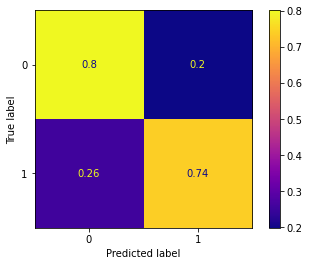

In [63]:
evaluate(output_rfc.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 4: Gradient Boosting Classifier

In [64]:
gbc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [65]:
cross_validate(gbc, X_tr, y_tr, return_train_score=True)

{'fit_time': array([ 9.84189081, 10.37368822, 10.36347747,  9.67916632, 10.30725574]),
 'score_time': array([0.10834503, 0.10443664, 0.10498476, 0.09829068, 0.10337305]),
 'test_score': array([0.85595424, 0.85387415, 0.84971399, 0.85487646, 0.84889467]),
 'train_score': array([0.86074633, 0.86074633, 0.8617865 , 0.86036534, 0.86160047])}

In [66]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth" : [1, 2, 5], 
    "classifier__learning_rate": [1, 0.1, 0.01],
}
# we have 2*3*3 = 18 many gradient boosting classifier models to run!

In [67]:
grid = GridSearchCV(gbc, param_grid, scoring=['f1','precision'], refit = 'f1') # 2*3*3*5 for CV

In [68]:
output_gbc = grid.fit(X_tr, y_tr)

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics

In [69]:
output_gbc.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 200}

In [70]:
output_gbc.best_estimator_.fit(X_tr, y_tr)

te_preds_gbc = output_gbc.best_estimator_.predict(X_te)

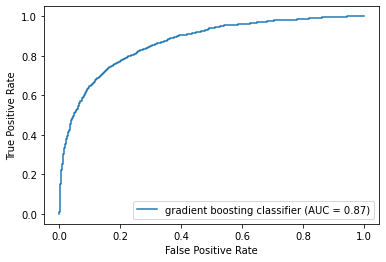

In [71]:
plot_roc_curve(output_gbc.best_estimator_, X_te, y_te, name='gradient boosting classifier');

Training Scores:
Train Accuracy: 0.895933014354067
Train Precision: 0.8400783289817232
Train Recall: 0.630110159118727
Train F1-Score: 0.7201007133864876
**********
Testing Scores:
Test Accuracy: 0.8548252911813644
Test Precision: 0.720108695652174
Test Recall: 0.5185909980430529
Test F1-Score: 0.602957906712173


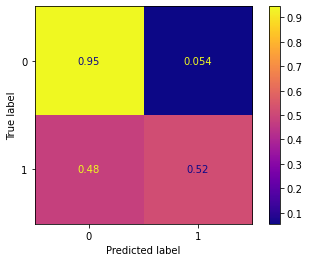

In [72]:
evaluate(output_gbc.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 5: kNN Classifier

In [73]:
kNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [74]:
cross_validate(kNN, X_tr, y_tr, return_train_score=True)

{'fit_time': array([7.58199048, 5.20951676, 7.20881629, 5.17618728, 5.27493143]),
 'score_time': array([9.47088742, 7.20966053, 7.27540898, 6.04629827, 6.23175192]),
 'test_score': array([0.79407176, 0.79849194, 0.78731149, 0.79193758, 0.79089727]),
 'train_score': array([0.8417631 , 0.84247822, 0.84390846, 0.84612884, 0.8466489 ])}

In [75]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_neighbors": [5, 10],
    "classifier__weights" : ['uniform', 'distance'], 
    "classifier__p": [1, 2, 3],
}

In [76]:
grid = GridSearchCV(kNN, param_grid, scoring=['f1','precision'], refit = 'f1')

In [77]:
output_kNN = grid.fit(X_tr, y_tr)

In [78]:
output_kNN.best_params_

{'classifier__n_neighbors': 5,
 'classifier__p': 1,
 'classifier__weights': 'distance'}

In [79]:
output_kNN.best_estimator_.fit(X_tr, y_tr)

te_preds_kNN = output_kNN.best_estimator_.predict(X_te)

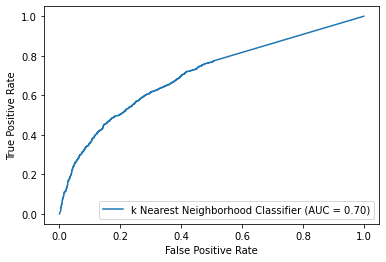

In [80]:
plot_roc_curve(output_kNN.best_estimator_, X_te, y_te, name='k Nearest Neighborhood Classifier');

Training Scores:
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-Score: 1.0
**********
Testing Scores:
Test Accuracy: 0.7999168053244592
Test Precision: 0.5622406639004149
Test Recall: 0.2651663405088063
Test F1-Score: 0.36037234042553196


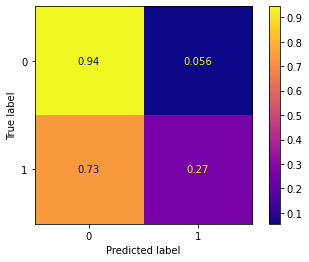

In [81]:
evaluate(output_kNN.best_estimator_, X_tr, X_te, y_tr, y_te)

### MODEL 6: XG Boosting Classifier

In [82]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgboost.XGBClassifier(random_state=42))
])

In [83]:
cross_validate(xgb, X_tr, y_tr, return_train_score=True)

{'fit_time': array([6.54678607, 6.24841571, 5.97556281, 5.32875085, 5.49929738]),
 'score_time': array([0.23182845, 0.21955347, 0.20246267, 0.18251181, 0.18650031]),
 'test_score': array([0.84711388, 0.85231409, 0.84607384, 0.85409623, 0.8426528 ]),
 'train_score': array([0.93856456, 0.93973475, 0.94753608, 0.93954365, 0.94331405])}

In [84]:
# Let's do GridSearchCV
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth" : [1, 2], 
    "classifier__learning_rate": [1, 0.1],
}


In [85]:
grid = GridSearchCV(xgb, param_grid, scoring=['f1','precision'], refit = 'f1')

In [86]:
output_xgb = grid.fit(X_tr, y_tr)

In [87]:
output_xgb.best_params_

{'classifier__learning_rate': 1,
 'classifier__max_depth': 2,
 'classifier__n_estimators': 100}

In [88]:
output_xgb.best_estimator_.fit(X_tr, y_tr)

te_preds_xgb = output_xgb.best_estimator_.predict(X_te)

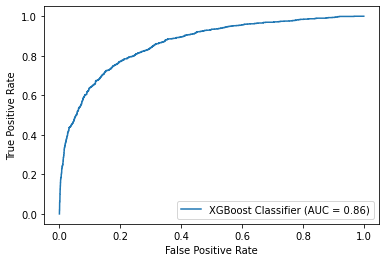

In [89]:
plot_roc_curve(output_xgb.best_estimator_, X_te, y_te, name='XGBoost Classifier');

Training Scores:
Train Accuracy: 0.8668088204701477
Train Precision: 0.7565656565656566
Train Recall: 0.5500611995104039
Train F1-Score: 0.6369950389794472
**********
Testing Scores:
Test Accuracy: 0.8508735440931781
Test Precision: 0.7126917712691772
Test Recall: 0.5
Test F1-Score: 0.5876940770557791


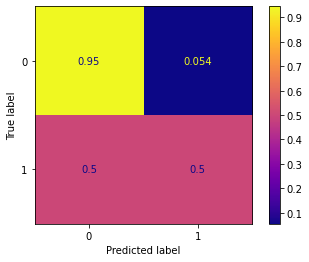

In [90]:
evaluate(output_xgb.best_estimator_, X_tr, X_te, y_tr, y_te,)

## Comparison of Model ROC Curves

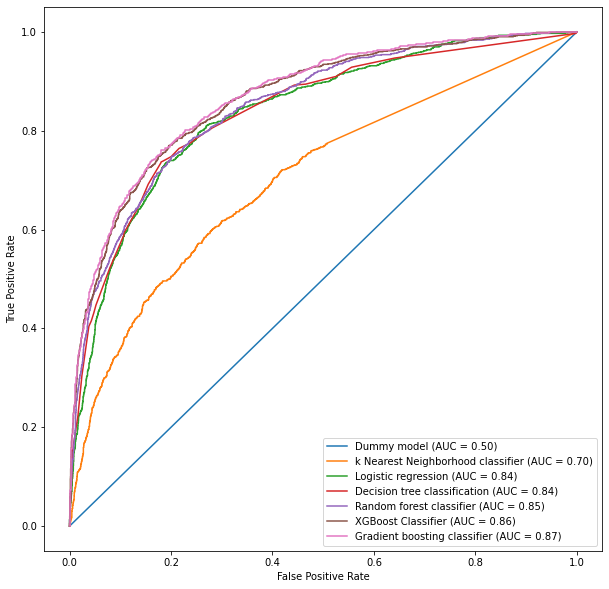

In [109]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(dummy_model, X_te, y_te,
               name='Dummy model', ax=ax)
plot_roc_curve(output_kNN.best_estimator_, X_te, y_te, 
               name='k Nearest Neighborhood classifier', ax=ax)
plot_roc_curve(output_logreg.best_estimator_, X_te, y_te, 
               name='Logistic regression', ax=ax)
plot_roc_curve(output_clf.best_estimator_, X_te, y_te,
               name='Decision tree classification', ax=ax)
plot_roc_curve(output_rfc.best_estimator_, X_te, y_te, 
               name='Random forest classifier', ax=ax)
plot_roc_curve(output_xgb.best_estimator_, X_te, y_te, 
               name='XGBoost Classifier', ax=ax)
plot_roc_curve(output_gbc.best_estimator_, X_te, y_te, 
               name='Gradient boosting classifier', ax=ax);

### 'Final' Model: Gradient Boosting Classifier

From the ROC curves comparison above, and confusion matrix of the method showing the best precision score among all the methods implemented, we decided to choose Gradient Boosting Classifier as our final model. 

In [92]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(learning_rate =0.1, n_estimators=200, 
                                              max_depth=5,
                                              random_state=42))
])

In [93]:
output_final_model = final_model.fit(X_tr, y_tr)

In [94]:
hold_preds_final_model = final_model.predict(X_hold)

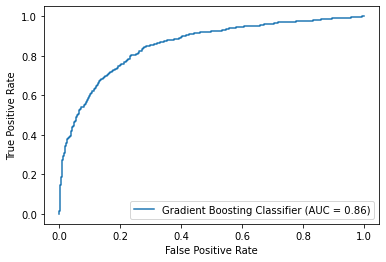

In [95]:
plot_roc_curve(final_model, X_hold, y_hold, name='Gradient Boosting Classifier');

Training Scores:
Train Accuracy: 0.895933014354067
Train Precision: 0.8400783289817232
Train Recall: 0.630110159118727
Train F1-Score: 0.7201007133864876
**********
Testing Scores:
Test Accuracy: 0.8476226132534631
Test Precision: 0.7051282051282052
Test Recall: 0.48500881834215165
Test F1-Score: 0.5747126436781609


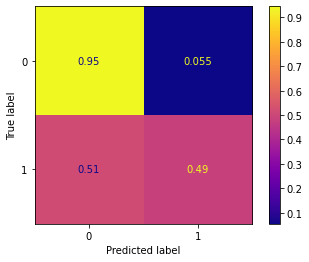

In [96]:
evaluate(final_model, X_tr, X_hold, y_tr, y_hold)

Our model did not overfit to the training set, we got similar AUC, precision and accuracy scores for the holdout set. We can generalize our model to unseen data.

### Feature Importance 

In [97]:
final_model['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral...
                                 ['age_group', 'education', 'race', 'sex',
                                  'in

In [98]:
final_model['preprocessor'].fit_transform(X_tr).shape

(19228, 59)

In [99]:
pd.DataFrame(final_model['preprocessor'].fit_transform(X_tr)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,1.000000,0.5,0.016076,0.963804,0.038064,0.894508,0.0,1.000000,0.0,0.116478,0.141558,1.0,0.0,1.000000,0.779010,0.75,0.296807,0.75,0.75,0.279800,0.75,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.106407,0.499168,0.504213
1,0.666667,1.0,0.016076,0.000000,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,0.0,0.110629,0.920662,0.75,0.765602,0.25,0.75,0.759933,0.25,0.333333,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.160235,0.340961,0.371854
2,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,0.0,1.000000,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.00,1.00,0.279800,0.00,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.076659,0.499168,0.504213
3,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.25,0.75,0.279800,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.499168,0.504213
4,0.333333,1.0,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,1.0,1.000000,0.920662,0.25,0.062409,0.00,0.75,0.279800,0.25,0.666667,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.340961,0.371854


In [100]:
final_model['classifier'].feature_importances_

array([1.11492608e-02, 1.16198447e-02, 5.50352362e-03, 3.14729500e-03,
       5.05099935e-03, 3.02963189e-03, 2.89312301e-03, 3.00118538e-03,
       1.48503032e-03, 3.04514685e-01, 2.08734341e-02, 7.16371985e-03,
       8.33912735e-03, 3.79441735e-02, 1.63029370e-01, 1.19087364e-01,
       9.45289860e-02, 1.36968164e-02, 1.29758084e-02, 3.14383678e-02,
       1.11118335e-02, 8.91720376e-03, 7.43287360e-03, 2.67321629e-03,
       2.48171435e-03, 1.56316928e-03, 4.27999277e-03, 6.97286357e-03,
       2.28525154e-03, 5.63344331e-03, 5.39853837e-03, 1.34372476e-03,
       3.79157693e-03, 5.20576056e-03, 1.97704964e-03, 1.94393889e-03,
       2.94627450e-03, 2.53498163e-03, 1.98454794e-03, 1.53787250e-03,
       2.92085468e-03, 1.71900606e-03, 1.85018762e-03, 2.24159242e-03,
       2.11303485e-03, 2.87282421e-04, 8.72081871e-04, 2.57243362e-03,
       9.00035843e-04, 1.70701140e-03, 1.24244582e-03, 1.81431173e-03,
       1.98048835e-03, 1.89024640e-03, 1.68921617e-03, 2.29535857e-03,
      

In [101]:
final_model['preprocessor'].transformers_[0][2]

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [102]:
# we want to make sure we have the same num_cols as the preprocessed one!
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [103]:
# These are ohe_transformed columns!
ohe_cols_transformed = final_model['preprocessor'].transformers_[1][1]['ohe_encoder'].get_feature_names(ohe_cols)
ohe_cols_transformed

array(['age_group_18 - 34 Years', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'education_Unknown', 'race_Black',
       'race_Hispanic', 'race_Other or Multiple', 'race_White',
       'sex_Female', 'sex_Male',
       'income_poverty_<= $75,000, Above Poverty',
       'income_poverty_> $75,000', 'income_poverty_Below Poverty',
       'income_poverty_Unknown', 'marital_status_Married',
       'marital_status_Not Married', 'marital_status_Unknown',
       'rent_or_own_Own', 'rent_or_own_Rent', 'rent_or_own_Unknown',
       'employment_status_Employed',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed', 'employment_status_Unknown',
       'census_msa_MSA, Not Principle  City',
       'census_msa_MSA, Principle City', 'census_msa_Non-MSA'],
      dtype=object)

In [104]:
final_model['preprocessor'].transformers_[2][2]

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [105]:
freq_cols

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [106]:
final_cols = [*num_cols, *ohe_cols_transformed, *freq_cols]
final_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'age_group_18 - 34 Years',
 'age_group_35 - 44 Years',
 'age_group_45 - 54 Years',
 'age_group_55 - 64 Years',
 'age_group_65+ Years',
 'education_12 Years',
 'education_< 12 Years',
 'education_College Graduate',
 'education_Some College',
 'education_Unknown',
 'race_Black',
 'race_Hispanic',
 'race_Other or Multiple',
 'race_White',
 'sex_Female',
 'sex_Male',
 'income_poverty_<= $75,000, Above Poverty',
 'income

In [107]:
# putting together the final cols and the feature importances!
# plus sorting by feature importances
pd.DataFrame.from_dict(dict(zip(final_cols, final_model['classifier'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False)

,0
doctor_recc_h1n1,0.304515
health_insurance,0.163029
opinion_h1n1_vacc_effective,0.119087
opinion_h1n1_risk,0.094529
health_worker,0.037944
opinion_seas_risk,0.031438
doctor_recc_seasonal,0.020873
hhs_geo_region,0.015760
opinion_h1n1_sick_from_vacc,0.013697
opinion_seas_vacc_effective,0.012976
